<Figure size 1200x800 with 0 Axes>

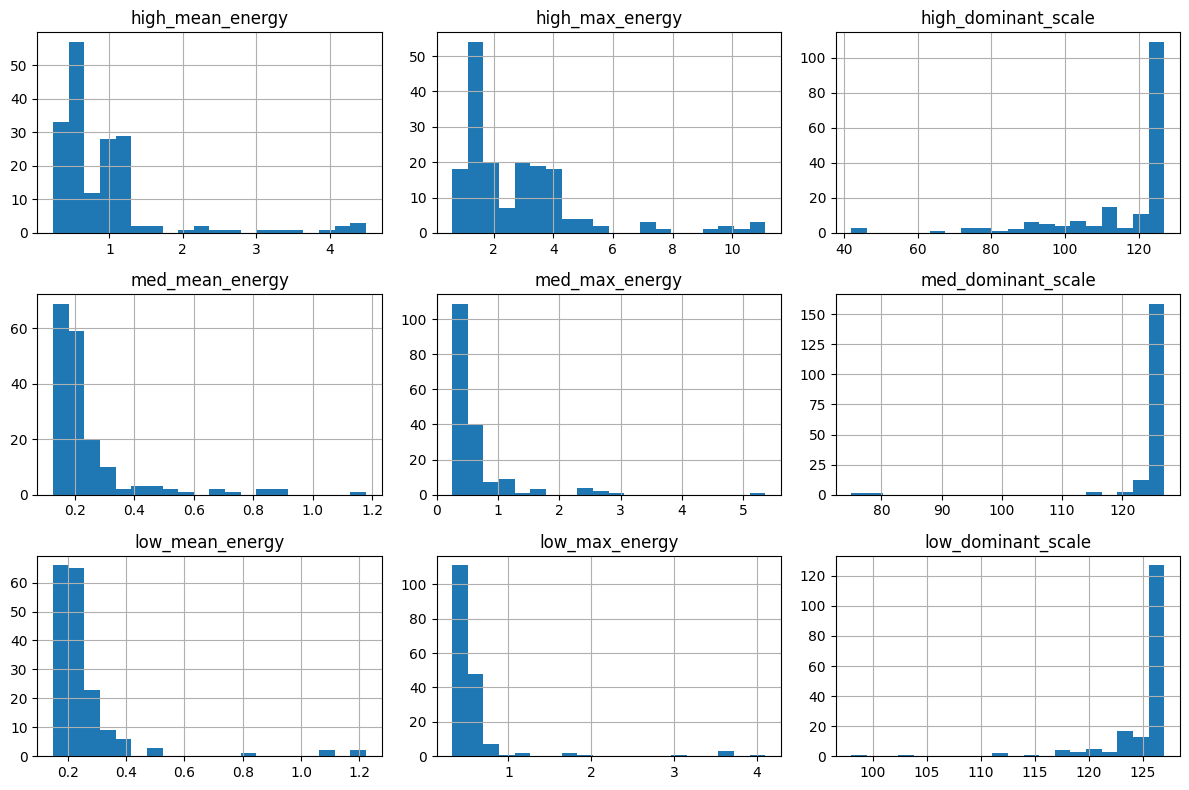

In [3]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from datetime import datetime

def construct_datetime(row):
    return datetime(int(row['Year']), int(row['Month']), int(row['Date']), int(row['Hour']))

def extract_wavelet_features(data, scales, wavelet='morl'):
    coefficients, _ = pywt.cwt(data, scales, wavelet)
    energy = np.mean(np.abs(coefficients)**2, axis=1)
    return np.mean(energy), np.max(energy), scales[np.argmax(energy)]

def process_risk_files(file_list, min_points=10):
    dfs = [pd.read_csv(f) for f in file_list]
    df = pd.concat(dfs, ignore_index=True)
    df.columns = df.columns.str.strip()
    df['MODZCTA'] = df['MODZCTA'].astype(int).astype(str)
    df['Datetime'] = df.apply(construct_datetime, axis=1)
    df = df.sort_values('Datetime')
    feats = []
    scales = np.arange(1, 128)
    for mod, group in df.groupby('MODZCTA'):
        group = group.sort_values('Datetime')
        if len(group) >= min_points:
            ts = group['Count'].values
            me, max_e, dom_scale = extract_wavelet_features(ts, scales, 'morl')
            feats.append({'MODZCTA': mod, 'mean_energy': me, 'max_energy': max_e, 'dominant_scale': dom_scale})
    return pd.DataFrame(feats)

high_files = ['HighRiskData_Temporal.csv']
med_files = ['MediumRiskData_Temporal_1.csv', 'MediumRiskData_Temporal_2.csv']
low_files = ['LowRiskData_Temporal_1.csv', 'LowRiskData_Temporal_2.csv']

wf_high = process_risk_files(high_files)
wf_med = process_risk_files(med_files)
wf_low = process_risk_files(low_files)

wf_high = wf_high.rename(columns={'mean_energy':'high_mean_energy','max_energy':'high_max_energy','dominant_scale':'high_dominant_scale'})
wf_med = wf_med.rename(columns={'mean_energy':'med_mean_energy','max_energy':'med_max_energy','dominant_scale':'med_dominant_scale'})
wf_low = wf_low.rename(columns={'mean_energy':'low_mean_energy','max_energy':'low_max_energy','dominant_scale':'low_dominant_scale'})

wf_combined = wf_high.merge(wf_med, on='MODZCTA', how='outer').merge(wf_low, on='MODZCTA', how='outer')
wf_combined.to_csv('wavelet_features.csv', index=False)

def visualize_wavelet_features(df):
    plt.figure(figsize=(12,8))
    cols = [col for col in df.columns if col != 'MODZCTA']
    df[cols].hist(bins=20, figsize=(12,8))
    plt.tight_layout()
    plt.show()

visualize_wavelet_features(wf_combined)
